# Hit song classifier

We make a hit song classifier. We define binary classifier, hit = 1, non-hit =0. See details of this below.

XGBoost results:
* Classification accuracy on training set: 0.982
* Classification accuracy on test set: 0.943
* MSE on training set: 0.018
* MSE on test set: 0.018

Random forest results:
* Classification accuracy on training set: 0.998
* Classification accuracy on test set: 0.987
* MSE on training set: 0.002
* MSE on test set: 0.013

In [1]:
#importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import math
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score as f1
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.linear_model import LinearRegression as linreg
from sklearn.metrics import mean_squared_error as rmse

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score ,roc_auc_score as auc, accuracy_score as acc, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve,average_precision_score,average_precision_score as aps,log_loss as ll

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import FitFailedWarning
import warnings
warnings.simplefilter(action='ignore', category=FitFailedWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
from sklearn.tree import DecisionTreeRegressor as dtr,export_graphviz
from sklearn.model_selection import GridSearchCV as gs, RandomizedSearchCV as rs
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBRegressor as xgbr

In [34]:
r=42 # random state
data = pd.read_csv('spotify_data.csv')
print(data.shape)
data.head(5)

(3441197, 7)


,Position,Track Name,Artist,Streams,URL,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,ec


In [2]:
data.dropna(inplace=True) # remove empty rows
data.drop(['URL'], axis=1,inplace=True) # remove url column
data['Date'] = pd.to_datetime(data['Date'], format= '%Y-%m-%d')
date_data = pd.DataFrame({"Year": data['Date'].dt.year,
              "Month": data['Date'].dt.month,
              "Day Of Month": data['Date'].dt.day,
              "Day Of Year": data['Date'].dt.dayofyear,
              "Day Of Week": data['Date'].dt.dayofweek,
              "Day Of Week Name": data['Date'].dt.day_name()
             })
data=data.join(date_data.set_index(data.index), on=data.index).copy() # joining date_data to data and removing original date column
data.drop(['Date'], axis=1,inplace=True)
le = preprocessing.LabelEncoder()
data['Track Name']=le.fit_transform(data['Track Name'])
data['Artist']=le.fit_transform(data['Artist'])
data['Region']=le.fit_transform(data['Region'])
data.drop(['Day Of Week Name'], axis=1,inplace=True)
data.head()

,Position,Track Name,Artist,Streams,Region,Year,Month,Day Of Month,Day Of Year,Day Of Week
0,1,12081,897,19272,15,2017,1,1,1,6
1,2,2412,5194,19270,15,2017,1,1,1,6
2,3,10924,6331,15761,15,2017,1,1,1,6
3,4,15445,4854,14954,15,2017,1,1,1,6
4,5,12461,2523,14269,15,2017,1,1,1,6


In [3]:
data.describe()


,Position,Track Name,Artist,Streams,Region,Year,Month,Day Of Month,Day Of Year,Day Of Week
count,3.440540e+06,3.440540e+06,3.440540e+06,3.440540e+06,3.440540e+06,3.440540e+06,3.440540e+06,3.440540e+06,3.440540e+06,3.440540e+06
mean,9.465220e+01,8.852871e+03,3.069436e+03,5.188452e+04,2.588895e+01,2.017025e+03,6.452594e+00,1.543292e+01,1.805010e+02,2.998390e+00
std,5.739412e+01,5.061674e+03,1.783667e+03,2.017733e+05,1.599017e+01,1.549684e-01,3.520916e+00,8.791304e+00,1.079724e+02,2.003664e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,1.001000e+03,0.000000e+00,2.017000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.500000e+01,4.341000e+03,1.562000e+03,3.321000e+03,1.200000e+01,2.017000e+03,3.000000e+00,8.000000e+00,8.600000e+01,1.000000e+00
50%,9.200000e+01,9.094000e+03,3.013000e+03,9.226000e+03,2.500000e+01,2.017000e+03,7.000000e+00,1.500000e+01,1.820000e+02,3.000000e+00
75%,1.430000e+02,1.335100e+04,4.584000e+03,2.965600e+04,4.000000e+01,2.017000e+03,1.000000e+01,2.300000e+01,2.740000e+02,5.000000e+00
max,2.000000e+02,1.859600e+04,6.627000e+03,1.138152e+07,5.300000e+01,2.018000e+03,1.200000e+01,3.100000e+01,3.650000e+02,6.000000e+00


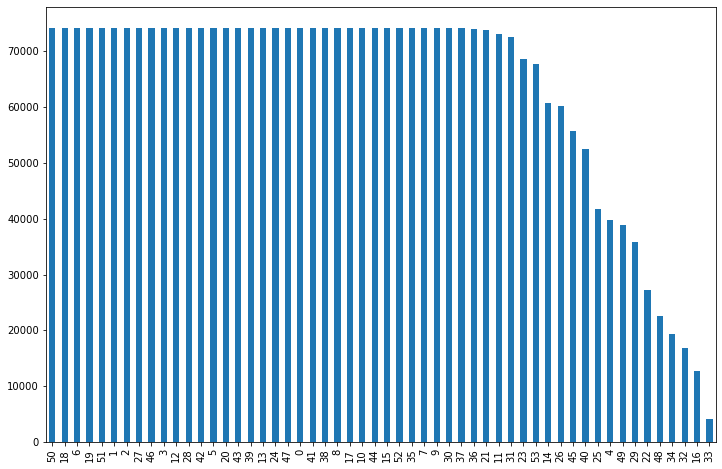

In [4]:
region_counts = data['Region'].value_counts()
ax = region_counts.plot(kind="bar",figsize=(12,8))

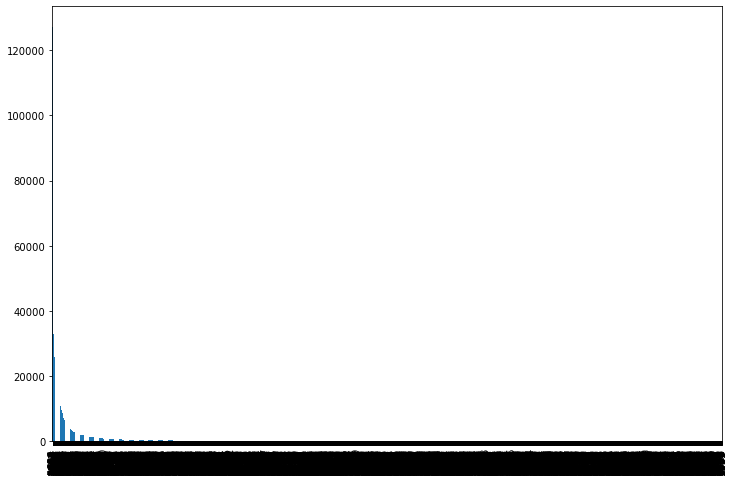

In [5]:
artist_counts = data['Artist'].value_counts()
ax = artist_counts.plot(kind="bar",figsize=(12,8))

## Hit or non-hit

We consider songs that were in the top 40 as hits and songs in the 55-100 positions as non-hits as these datasets are about the same size.

From this we can build classifier models that will either class a new data instance as a non-hit (0) or a hit (1).

These boundaries can be easily changed, the current size of boundary was selected so as to have a large portion of data but to still be small enough that the code runs quickly. 

In [6]:
a = 40 # below a is hits
b = 100 # below b is nonhits
c = 55 # above c is nonhits 
print(len(data[data['Position']<=a]))
print(len(data[data['Position']<=b])-len(data[data['Position']<=c]))

781711
804504


In [7]:
hits = data[data['Position']<=a]
hits['Hits'] = 1
hits.shape

(781711, 11)

In [8]:
hits.head(5)

,Position,Track Name,Artist,Streams,Region,Year,Month,Day Of Month,Day Of Year,Day Of Week,Hits
0,1,12081,897,19272,15,2017,1,1,1,6,1
1,2,2412,5194,19270,15,2017,1,1,1,6,1
2,3,10924,6331,15761,15,2017,1,1,1,6,1
3,4,15445,4854,14954,15,2017,1,1,1,6,1
4,5,12461,2523,14269,15,2017,1,1,1,6,1


In [9]:
nonhits = data[data['Position']>=c]
nonhits = nonhits[nonhits['Position']<=b]
nonhits['Hits'] = 0
nonhits.shape

(823299, 11)

In [10]:
nonhits.head(5)

,Position,Track Name,Artist,Streams,Region,Year,Month,Day Of Month,Day Of Year,Day Of Week,Hits
54,55,8994,1192,3180,15,2017,1,1,1,6,0
55,56,12334,3069,3085,15,2017,1,1,1,6,0
56,57,6372,5754,3022,15,2017,1,1,1,6,0
57,58,5245,2523,3005,15,2017,1,1,1,6,0
58,59,16221,4858,2967,15,2017,1,1,1,6,0


In [11]:
nonhits.shape

(823299, 11)

In [12]:
nonhits.head(5)

,Position,Track Name,Artist,Streams,Region,Year,Month,Day Of Month,Day Of Year,Day Of Week,Hits
54,55,8994,1192,3180,15,2017,1,1,1,6,0
55,56,12334,3069,3085,15,2017,1,1,1,6,0
56,57,6372,5754,3022,15,2017,1,1,1,6,0
57,58,5245,2523,3005,15,2017,1,1,1,6,0
58,59,16221,4858,2967,15,2017,1,1,1,6,0


In [13]:
dataset = pd.concat([hits, nonhits], axis="rows")

In [14]:
dataset.shape

(1605010, 11)

## Lets try some models

In [15]:
#X = dataset.loc[:, dataset.columns != 'Position'].copy()
X = dataset[['Track Name','Artist','Streams','Region']] # can vary which features we use
# currently ignoring date information
Y = dataset['Hits'].copy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=r,stratify=Y)

In [17]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

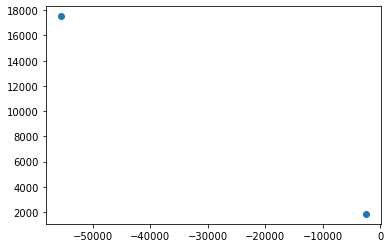

In [18]:
plt.scatter(X_2d[0],X_2d[1])

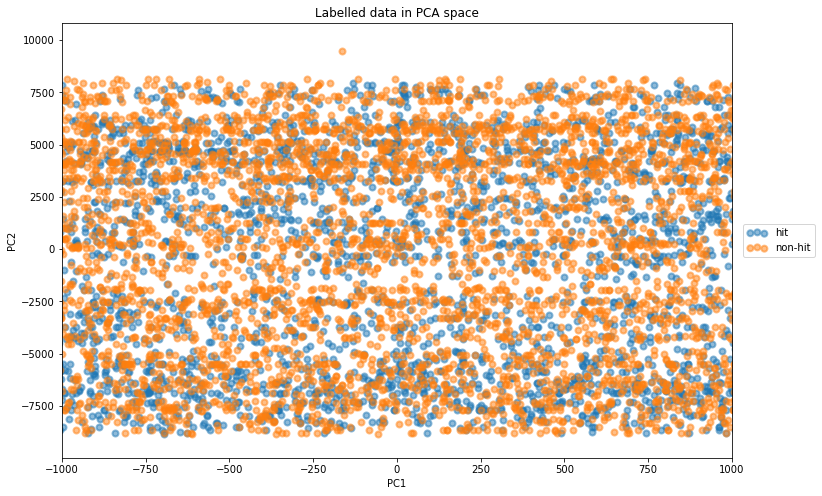

In [19]:
class_categories = ['non-hit', 'hit']
class_labels = [0,1]

sub_labels = [l for l in class_labels if l != 2]
sub_cats = [class_categories[label-1] for label in sub_labels]

plt.figure(figsize=(12,8))
for label, cat in zip(sub_labels, sub_cats):
    plt.scatter(X_2d[y_train == label, 0], X_2d[y_train == label, 1], alpha=.5, lw=2, label=cat)
#plt.axis('equal')
plt.legend(loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Labelled data in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-1000,1000)
top_plot = plt.gca()
plt.show()

In [20]:
#X_train, X_test, y_train, y_test = np.array(X_train).reshape(-1,1), np.array(X_test).reshape(-1,1), np.array(y_train).reshape(-1,1), np.array(y_test).reshape(-1,1)

In [21]:
gnb = GaussianNB() # Gaussian Naive Bayes
gnb.fit(X_train,y_train)
print('GNB Classification accuracy on training set: {:.3f}'.format(gnb.score(X_train, y_train)))
print('GNB Classification accuracy on test set: {:.3f}'.format(gnb.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,gnb.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,gnb.predict(X_test),squared=True)))

mnb = MultinomialNB() # Multinomial Naive Bayes
mnb.fit(X_train,y_train)
print('MNB Classification accuracy on training set: {:.3f}'.format(mnb.score(X_train, y_train)))
print('MNB Classification accuracy on test set: {:.3f}'.format(mnb.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,mnb.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,mnb.predict(X_test),squared=True)))

GNB Classification accuracy on training set: 0.521
GNB Classification accuracy on test set: 0.522
MSE on training set: 0.479
MSE on test set: 0.478
MNB Classification accuracy on training set: 0.590
MNB Classification accuracy on test set: 0.590
MSE on training set: 0.410
MSE on test set: 0.410


In [22]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X_train, y_train)))
print('Classification accuracy on test set: {:.3f}'.format(lr.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,lr.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,lr.predict(X_test),squared=True)))

Classification accuracy on training set: 0.584
Classification accuracy on test set: 0.584
MSE on training set: 0.416
MSE on test set: 0.416


In [23]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=r,max_depth=2)
dt.fit(X_train,y_train)

print('Classification accuracy on training set: {:.3f}'.format(dt.score(X_train, y_train)))
print('Classification accuracy on test set: {:.3f}'.format(dt.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,dt.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,dt.predict(X_test),squared=True)))

Classification accuracy on training set: 0.598
Classification accuracy on test set: 0.598
MSE on training set: 0.402
MSE on test set: 0.402


In [24]:
xgbmmodel = xgbr(random_state=r,verbosity=0)
xgbmmodel.fit(X_train,y_train)

print('Classification accuracy on training set: {:.3f}'.format(xgbmmodel.score(X_train, y_train)))
print('Classification accuracy on test set: {:.3f}'.format(xgbmmodel.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,xgbmmodel.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,xgbmmodel.predict(X_test),squared=True)))

Classification accuracy on training set: 0.944
Classification accuracy on test set: 0.943
MSE on training set: 0.014
MSE on test set: 0.014


In [29]:
xgbclassif = xgb.XGBClassifier(random_state=r,verbosity=0,max_depth=5) # using the xgboost classifier
xgbclassif.fit(X_train,y_train)

print('Classification accuracy on training set: {:.3f}'.format(xgbclassif.score(X_train, y_train)))
print('Classification accuracy on test set: {:.3f}'.format(xgbmmodel.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,xgbclassif.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,xgbclassif.predict(X_test),squared=True)))

Classification accuracy on training set: 0.982
Classification accuracy on test set: 0.943
MSE on training set: 0.018
MSE on test set: 0.018


In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rf = RandomForestClassifier(n_estimators=5, criterion='entropy')
rf.fit(X_train, y_train)

print('Classification accuracy on training set: {:.3f}'.format(rf.score(X_train, y_train)))
print('Classification accuracy on test set: {:.3f}'.format(rf.score(X_test, y_test)))

print('MSE on training set: {:.3f}'.format(rmse(y_train,rf.predict(X_train),squared=True)))
print('MSE on test set: {:.3f}'.format(rmse(y_test,rf.predict(X_test),squared=True)))

Classification accuracy on training set: 0.998
Classification accuracy on test set: 0.987
MSE on training set: 0.002
MSE on test set: 0.013
